# VMamba

### Data

In [74]:
import torch 

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.cuda.set_device(device)
print(device)

cuda:0


In [75]:
import torch
from torch.utils.data import Dataset
from torch.nn.functional import pad
import numpy as np

class ImageDataset(Dataset):
    def __init__(self, ds, split='train'):
        self.ds = ds[split]
        self.split = split

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        image = torch.tensor(np.array(self.ds[idx]['image'].convert("RGB")), dtype=torch.float32).transpose(-3, -1).cuda()
        label = torch.tensor(self.ds[idx]['label'], dtype=torch.long).cuda()
        
        return image, label

def get_padding(image, max_w, max_h):
    h_padding = (max_w - image.shape[-1])
    v_padding = (max_h - image.shape[-2])
    d_padding = (3 - image.shape[-3])
    
    padding = (0, h_padding, 0, v_padding, 0, d_padding)
    
    return padding

def pad_images(data):
        max_w = max([d[0].shape[-1] for d in data]) 
        max_h = max([d[0].shape[-2] for d in data])

        padded_imgs = torch.empty((len(data), 3, max_h, max_w))
        for i, d in enumerate(data):
             padding = get_padding(d[0], max_w, max_h)
             padded = pad(d[0], padding)
             padded_imgs[i] = padded

        return padded_imgs.cuda(), torch.tensor([d[1] for d in data]).cuda()
    
# test_pad = ds['train'][:3]['image']
# print([img.size for img in test_pad])

# print(get_padding(test_pad[0], 500, 500))
# padded = pad_images(test_pad)
# print([img.shape for img in padded])


In [76]:
from datasets import load_dataset
from torch.utils.data import DataLoader

ds = load_dataset("zh-plus/tiny-imagenet")
print(ds.shape)

train_data = ImageDataset(ds, split='train')
val_data = ImageDataset(ds, split='valid')

batch_size = 128

train_loader = DataLoader(train_data, batch_size=batch_size, collate_fn=pad_images, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, collate_fn=pad_images, shuffle=True)

{'train': (100000, 2), 'valid': (10000, 2)}


### Model

In [77]:
import vmamba as vm
import torch
from torch import nn
import numpy as np

default_model = 'hilbert'
# default_model = 'standard'

models = {
    'standard': vm.vmamba_itty().cuda(),
    'hilbert': vm.vmamba_itty_hilbert().cuda(),
    }
    
# print([p.numel() for p in models[default_model][0].parameters()])
print(np.sum([p.numel() for p in models[default_model].parameters()], axis=0))
print(next(models[default_model].parameters()).device)

168904
cuda:0


In [78]:
import numpy as np

input, label = next(iter(train_loader))
print('in', input.shape)
print(torch.argmax(models[default_model](input), dim=-1))
print(label)

in torch.Size([128, 3, 64, 64])
tensor([135, 122,  98,  98,  98, 135, 122, 122, 135,  98, 135, 135,  98, 122,
         98, 122, 122, 135, 135, 135,  85,  98,  98, 135, 122, 122, 122,  79,
        135, 135,  98,  98, 135, 135, 122,  98, 135,  98, 122,  98, 122,  98,
        135, 135, 122,  79, 122,  98,  98, 135,  98, 135, 122,  98,  98,  98,
        135, 122,  98, 135, 135, 122,  80,  98, 122, 122, 135,  98, 135,  98,
        122,  98,  98,  85, 135, 135,  79, 122, 122, 135, 135, 122, 122, 135,
        135,  98,  98, 122, 135,  98, 135, 122,  98, 122, 135, 135, 122, 122,
         98,  98, 122, 135,  98,  85,  98,  98, 122, 122,  98, 122, 135, 135,
        122, 122,  98, 122, 122, 135,  98,  98, 122, 122, 135,  85, 135,  98,
        135,  98], device='cuda:0')
tensor([ 37,  87, 164, 119, 190, 150, 143,  91,  71, 183,   8, 175, 122, 191,
        136,  25, 146,  11, 128, 146,  12, 161,  48, 193,  94, 190, 145,  29,
         90, 103,  20,  75, 145,  39, 129,  61, 180, 106,   8,  95,  50, 1

### Training

In [79]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from typing import Dict, Tuple, List


# Assumes same optimizer and loss for each model
def train_compare(
      n_epochs:int, 
      models:Dict[str, nn.Module], 
      train_loader:DataLoader, 
      val_loader:DataLoader = None, 
      opt:torch.optim.Optimizer = torch.optim.AdamW, 
      loss_fn:nn.Module = nn.CrossEntropyLoss,
      verbose:int = 0
    ):

    train_losses = [[] for i in range(len(models))]
    val_losses = [[] for i in range(len(models))]

    report_freq = max(n_epochs // 10 * verbose, 1)

    tl = iter(train_loader)
    if val_loader is not None: vl = iter(val_loader)

    #initialize
    optimizers = [opt(mod.parameters(), lr=1e-2) for mod in models.values()]
    loss_fn = loss_fn()

    for m in models.keys(): print(f'\t{m}', end="")
    print()
    
    for e in range(n_epochs):
        train_X, train_y = next(tl)
        
        for i, (model, optimizer) in enumerate(zip(models.values(), optimizers)):
          model.train()
          optimizer.zero_grad()
          
          # Make predictions for this batch
          if verbose >= 2: print('forward, ', end="")
          train_out = model(train_X)
          
          
          # Compute the loss and its gradients
          if verbose >= 2: print('back, ', end="")
          loss = loss_fn(train_out, train_y)
          loss.backward()
          
          # Adjust learning weights
          if verbose >= 2: print('step', end="")
          optimizer.step()

          # Append training and validation loss to lists
          train_losses[i].append(loss.item())

          # Obtain training accuracy curve
          # training_accuracy_local = calculate_training_accuracy(model, data=_data_)
          # train_accuracy.append(training_accuracy_local)

          # Print information out
          if verbose >= 1 and e % report_freq == 0:
            if i < len(models)-1: print(f'{e:03d}:\t', end="") 
            print(f'{loss:.4f}\t', end="")
            print('\t' if i < len(models)-1 else '\n', end="")

          # Get validation losses
          if val_loader is not None:
            model.eval()
            val_X, val_y = next(vl)
            val_out = model(val_X)
            epoch_val_loss = loss_fn(val_out, val_y)
            val_losses[i].append(epoch_val_loss.item())

    if val_loader is None: return train_losses

    return train_losses, val_losses



In [ ]:
n_epochs = 100

train_loss = train_compare(n_epochs, models, train_loader, verbose=1)
# print(train_loss)

	standard	hilbert
000:	5.2888		5.3293	
010:	5.4140		5.4593	
020:	5.4328		5.3551	
030:	5.3684		5.3809	


### Plots

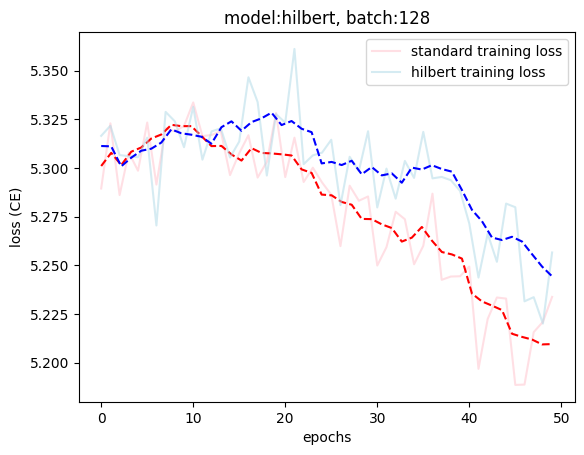

In [73]:
import matplotlib.pyplot as plt
import datetime
import numpy as np

def moving_average(y, window=10):
    average_y = []
    for ind in range(len(y) - window + 1):
        average_y.append(np.mean(y[ind:ind+window]))

    return np.array(average_y)

current_time = datetime.datetime.now()

t_colors = ['pink', 'lightblue']
avg_colors = ['red', 'blue']
for i, (model_name, model) in enumerate(models.items()):
    # if model_name == 'hilbert': continue
    
    t_loss = train_loss[i]
    # v_loss = train_loss[i]
    plt.plot(t_loss, label=f'{model_name} training loss', alpha=0.5, color=t_colors[i])
    # plt.plot(v_loss, label=f'{model_name} training loss', alpha=0.65, color=v_colors[i])
    # print(np.linspace(0, n_epochs-1, len(train_loss[i])))

    x = range(n_epochs)
    y = moving_average(t_loss, window=max(n_epochs//10, 1))
    plt.plot(np.linspace(0, n_epochs-1, len(y)), y,"--", color=avg_colors[i])

    plt.title(f'model:{model_name}, batch:{batch_size}')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss (CE)')
    
plt.savefig(f'output/M{model_name}B{batch_size}T{current_time}.png')

# Pathing Tests

In [24]:
import pathing
import torch
import numpy as np

# hcurve = torch.tensor([0, 1, 5, 4, 
#                        8, 12, 13, 9, 
#                        10, 14, 15, 11, 
#                        7, 6, 2, 3])
hcurve = torch.tensor([0, 1, 14, 15, 
                       3, 2, 13, 12, 
                       4, 7, 8 , 11,
                       5, 6, 9 , 10])

# print(torch.argsort(hcurve).reshape(4,4))

ten = torch.arange(0, 32).reshape((2,4,4))
print(ten)
hten = pathing.sort_by_indices(ten.flatten(), torch.argsort(hcurve)).reshape(4,4)
print(hten)
print(pathing.sort_by_indices(hten.flatten(), hcurve).reshape(4,4))

tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11],
         [12, 13, 14, 15]],

        [[16, 17, 18, 19],
         [20, 21, 22, 23],
         [24, 25, 26, 27],
         [28, 29, 30, 31]]])
tensor([[ 0,  1,  5,  4],
        [ 8, 12, 13,  9],
        [10, 14, 15, 11],
        [ 7,  6,  2,  3]])
tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]])


In [15]:
import spacefill.curvetools as ct
import numpy as np


# curve_map = ct.generate_map(90, 125)
x_size, y_size = 4, 5
curve_map = ct.generate_map(x_size, -y_size)
# print('Byte Size: {}'.format(sys.getsizeof(curve_map)))
# print('Amount of points: {}'.format(len(curve_map)))

# point = ct.coord_to_position((25, 25), curve_map)
# coord = ct.position_to_coord(point, curve_map)

import matplotlib.pyplot as plt
# print(curve_map)
print(curve_map[0])
px, py = list(zip(*(curve_map[0])))
inds = torch.tensor([(-y-1)*x_size + x for x, y in curve_map[0]], dtype=torch.int64)
print(inds.reshape(y_size,x_size))
print(torch.argsort(inds).reshape(y_size,x_size))
# px, py = dat
# plt.plot(px, py)
# plt.plot([coord[0]], [coord[1]], 'ro')
# plt.show()
print()
arr = torch.arange(0,x_size*y_size).reshape(y_size, x_size)
print(arr)
arr_sort = arr.flatten().gather(dim=-1, index=inds).reshape(y_size, x_size)
print(arr_sort)

[(0.0, -1.0), (1.0, -1.0), (1.0, -2.0), (0.0, -2.0), (0.0, -3.0), (0.0, -4.0), (0.0, -5.0), (1.0, -5.0), (1.0, -4.0), (1.0, -3.0), (2.0, -3.0), (2.0, -4.0), (2.0, -5.0), (3.0, -5.0), (3.0, -4.0), (3.0, -3.0), (3.0, -2.0), (2.0, -2.0), (2.0, -1.0), (3.0, -1.0)]
tensor([[ 0,  1,  5,  4],
        [ 8, 12, 16, 17],
        [13,  9, 10, 14],
        [18, 19, 15, 11],
        [ 7,  6,  2,  3]])
tensor([[ 0,  1, 18, 19],
        [ 3,  2, 17, 16],
        [ 4,  9, 10, 15],
        [ 5,  8, 11, 14],
        [ 6,  7, 12, 13]])

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15],
        [16, 17, 18, 19]])
tensor([[ 0,  1,  5,  4],
        [ 8, 12, 16, 17],
        [13,  9, 10, 14],
        [18, 19, 15, 11],
        [ 7,  6,  2,  3]])
